We start by importing all the libraries we are interested in.

In [1]:
import numpy as np
import astropy
import ccdproc
from ccdproc import CCDData, combiner
from astropy import units as u
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import gc                                 # What does this library do?
gc.enable()

Load in the images.

In [2]:
directory = "C11_2022_03_28"
images = ccdproc.ImageFileCollection("./C11_2022_03_28")    # loads in all of the image files
print(len(images.files))                                    # prints the number of files so we can make sure they have been loaded

326


# BIAS

We start by filtering the images to get the bias images

In [3]:
# stores the filenames list to a variable
filenames = ( images.files_filtered(PICTTYPE = 2) )

Printing a list of file names
['Bias_00003952.fits' 'Bias_00003953.fits' 'Bias_00003954.fits'
 'Bias_00003955.fits' 'Bias_00003956.fits' 'Bias_00003957.fits'
 'Bias_00003958.fits' 'Bias_00003959.fits' 'Bias_00003960.fits'
 'Bias_00003961.fits' 'Bias_00003962.fits' 'Bias_00003963.fits'
 'Bias_00003964.fits' 'Bias_00003965.fits' 'Bias_00003966.fits'
 'Bias_00003967.fits' 'Bias_00003968.fits' 'Bias_00003969.fits'
 'Bias_00003970.fits' 'Bias_00003971.fits' 'Bias_00003972.fits'
 'Bias_00003973.fits' 'Bias_00003974.fits' 'Bias_00003975.fits'
 'Bias_00003976.fits' 'Bias_00003977.fits' 'Bias_00003978.fits'
 'Bias_00003979.fits' 'Bias_00003980.fits' 'Bias_00003981.fits'
 'Bias_00003982.fits' 'Bias_00003983.fits' 'Bias_00003984.fits'
 'Bias_00003985.fits' 'Bias_00003986.fits' 'Bias_00003987.fits'
 'Bias_00003988.fits' 'Bias_00003989.fits' 'Bias_00003990.fits'
 'Bias_00003991.fits' 'Bias_00003992.fits' 'Bias_00003993.fits'
 'Bias_00003994.fits' 'Bias_00003995.fits' 'Bias_00003996.fits'
 'Bias_000

We then need to read in the bias images.

In [34]:
biases = [ CCDData.read(directory + '/' + fn, unit = "adu") for fn in filenames ]

print(len(biases), ' bias images loaded')

100  bias images loaded


We then compute some statistics for the first bias image, to make sure it looks good.

In [36]:
# uses numpy to compute the min, max, standard deviation, and mean of the first bias image
print('Min:', np.min(biases[0]))
print('Max:', np.max(biases[0]))
print('Standard deviation:', np.std(biases[0]))
print('Median:', np.median(biases[0]))

Min: 1938
Max: 2317
Standard deviation: 33.496370739683385
Median: 2088.0


A bias of about 2000 is expected, so this looks reasonable.

Now we combine the bias images.

In [9]:
bias_median = ccdproc.Combiner(biases, dtype=np.float32).median_combine()

# A good habit to get into is printing the statistics of input and output images
print('Image statistics for the median bias')

thisimage=bias_median
print('Min:', np.min(thisimage))
print('Max:', np.max(thisimage))
print('Median:', np.median(thisimage))
print('Std Dev:', np.std(thisimage))


Image statistics for the median bias
Min: 2048.5
Max: 2233.0
Median: 2079.0
Std Dev: 14.54244327545166


/home/sparks/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


The range of values is smaller than in the individual image, and the standard deviation is also smaller. This means that our combine has done its job - we have mitigated the noise in the images. The median is 9 counts smaller than the median of the first image. We expect all of the biases to be similar, so it is reassuring that the median of the first image is close to the median of the combined images.

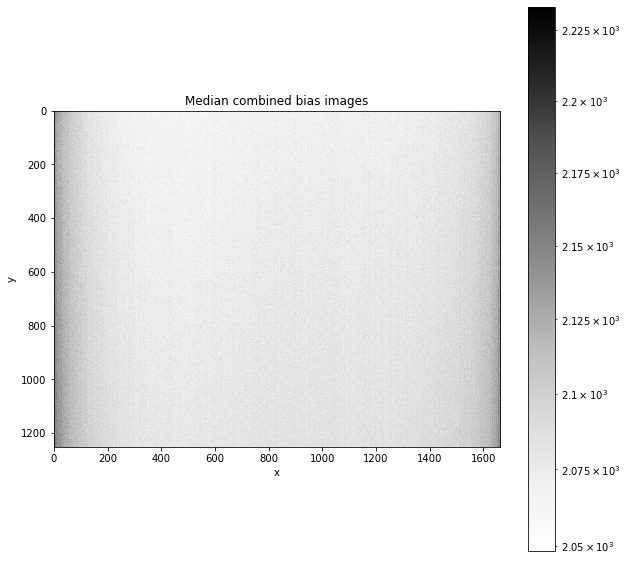

In [37]:
fig, ax = plt.subplots(figsize = (10,10))
plt.imshow(bias_median, cmap = 'Greys', norm = LogNorm())
plt.title('Median combined bias images')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [38]:
bias_median.meta.update(EXPTIME = 0)                              # add the exposure time
bias_median.meta.update(TELESCOP = biases[0].header['TELESCOP'])  # add the telescope used
bias_median.meta.update(OBJECT = 'Bias_Median')                   # add the object name to identify this image as the median combined bias image
print(bias_median.meta)

OrderedDict([('NCOMBINE', 100), ('EXPTIME', 0), ('TELESCOP', 'C11'), ('OBJECT', 'Bias_Median')])


In [39]:
bias_median.write("bias_median.fits")     # writes the median combined bias image to a FITS file called 'bias_median.fits'

OSError: File 'bias_median.fits' already exists.

In [40]:
# delete the bias data from the jupyter notebook to clear the memory
del(biases)
collected = gc.collect()
print('Check garbage collection', collected)

Check garbage collection 10272


# DARK

In [20]:
# loops through the filenames and reads the data for each file
darks = [ CCDData.read(directory + '/' + fn, unit = "adu") for fn in images.files_filtered(PICTTYPE = 3) ]

Set OBSGEO-Y to  2896022.315 from OBSGEO-[LBH].
Set OBSGEO-Z to -3889419.901 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to  2896022.315 from OBSGEO-[LBH].
Set OBSGEO-Z to -3889419.901 from OBSGEO-[LBH]'.


In [21]:
len(darks)

6

In [ ]:
image = darks[0]

print('Exposure time:',image.header['EXPTIME'], 'seconds')

print('Min:', np.min(image))
print('Max:', np.max(image))
print('Median:', np.median(image))
print('Std Dev:', np.std(image))

In [22]:
for idx, thisimage in enumerate(darks): 
    darks[idx] = ccdproc.subtract_bias(thisimage, bias_median)

In [ ]:
image = darks[0]
print('Image statistics for the 0th dark image')

print('Counts (ADU) for pixels 500 to 509 in column 500')
print(image[500:510,500])

print('Exposure time:',image.header['EXPTIME'], 'seconds')

print('Electrons per minute for pixels 500 to 509 in column 500')
print(np.array(image[500:510,500])/image.header['EXPTIME']*image.header['EGAIN']*60)

print('Min:', np.min(image))
print('Max:', np.max(image))
print('Median:', np.median(image))
print('Std Dev:', np.std(image))

fig, ax = plt.subplots(figsize = (10,10))
plt.imshow(image, cmap = 'Greys', norm = LogNorm())
plt.title('Dark image 0 with bias subtracted')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [23]:
dark_median = ccdproc.Combiner(darks, dtype=np.float32).median_combine() # median combine the dark images

In [ ]:
print('Statistics for median-combined dark image')

print('Counts (ADU) for pixels 500 to 509 in column 500')
print(dark_median[500:510,500])

print('Electrons per minute for pixels 500 to 509 in column 500')
print(np.array(dark_median[500:510,500])/image.header['EXPTIME']*image.header['EGAIN']*60)

print('Min:', np.min(dark_median))
print('Max:', np.max(dark_median))
print('Median:', np.median(dark_median))
print('Std Dev:', np.std(dark_median))

fig, ax = plt.subplots(figsize = (10,10))
plt.imshow(dark_median, cmap = 'Greys', norm = LogNorm())
plt.title('Median dark with bias subtracted')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [25]:
dark_median.meta.update(EXPTIME = 3600)           # add exposure time to dark_median header
dark_median.meta.update(TELESCOP = 'C14')         # add telescope used
dark_median.meta.update(OBJECT = 'Dark_Median')   # add object name so we can identify the dark median image
dark_median.write("dark_median.fits")             # write the dark_median image to a fits file

In [ ]:
del(darks)
collected = gc.collect()
print('Check garbage collection', collected)

# FLATS

Filter the images to get the R-band flats.

In [16]:
# load in the R-band flats
flats = [ CCDData.read(directory + '/' + fn, unit = "adu") for fn in images.files_filtered(PICTTYPE = 4) if 'Flat_R_' in fn]


Set OBSGEO-Y to  2896022.315 from OBSGEO-[LBH].
Set OBSGEO-Z to -3889419.901 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to  2896022.315 from OBSGEO-[LBH].
Set OBSGEO-Z to -3889419.901 from OBSGEO-[LBH]'.


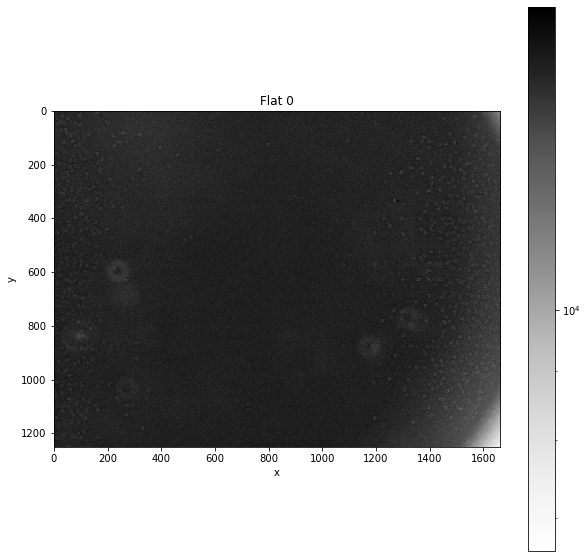

In [17]:
fig, ax = plt.subplots(figsize = (10,10))
plt.imshow(flats[0], cmap = 'Greys', norm = LogNorm())
plt.title('Flat 0')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [26]:
# loop through flats and subtract bias from each of them, and overwrite the counts with the bias-subtracted values
for idx, thisimage in enumerate(flats): 
    flats[idx] = ccdproc.subtract_bias(thisimage, bias_median)
print('First column of first flat image after bias subtraction:')
print(flats[0][:,0])

# loop through flats and subtract darks, scaled by exposure time, for each of them
# then overwrite the counts with the dark-subtracted values
for idx, thisimage in enumerate(flats): 
    flats[idx] = ccdproc.subtract_dark(thisimage, dark_median, exposure_time = 'EXPTIME',
                                       exposure_unit = u.second, scale = True)
print('First column of first flat image after dark subtraction:')
print(flats[0][:,0]) 

First column of first flat image after bias subtraction:
[8751.  8537.5 8385.  ... 8642.  8694.  8690. ] adu
First column of first flat image after dark subtraction:
[8750.81166667 8537.30166666 8384.80958334 ... 8641.95236111 8693.93972222
 8689.94569444] adu


In [27]:
for thisimage in flats:
    print('Median:', np.ma.median(thisimage.data))  

Median: 8772.921874996275
Median: 8650.930555552244
Median: 8528.904722221196
Median: 8408.447708332911
Median: 8288.932499997318
Median: 8170.409305550158
Median: 8050.431527778506
Median: 7930.937638886273
Median: 7816.409027777612
Median: 7699.9136111065745
Median: 7587.4136111065745
Median: 7475.925833329558
Median: 7365.933749996126
Median: 7255.440555553883
Median: 7148.4083333313465
Median: 7040.438472222537
Median: 6935.926041666418
Median: 6830.934722222388
Median: 6725.918472222984
Median: 6621.939166665077


Since the sky gets darker as we take the flats, we need to normalise the flats.

In [29]:
tempimages = flats.copy() # create a copy of the flat images

for idx, thisimage in enumerate(tempimages):    # loop through the copies of the flat images
    m = 1.0 / np.ma.median(tempimages[idx])     # calculate a normalisation constant by dividing 1 by the median value of the current flat image
    tempimages[idx] = tempimages[idx].multiply(m * u.adu)    # multiply the counts by the normalisation constant so that the median should now be 1

# median combine the normalised flat images    
FlatR_median = ccdproc.Combiner(tempimages, dtype=np.float32).median_combine()

Statistics for median-combined flat image
[[0.9681595  0.9617733  0.9646611  ... 0.4629926  0.45882523 0.45501542]
 [0.9660729  0.9697918  0.9743662  ... 0.46852422 0.46412772 0.45109436]
 [0.96270144 0.9607561  0.9735917  ... 0.47287858 0.45731086 0.45278752]
 ...
 [0.98012614 0.9839437  0.9846323  ... 0.03685597 0.03202151 0.02779013]
 [0.98190176 0.97940725 0.99424505 ... 0.02414737 0.02967928 0.02083587]
 [0.989448   0.97951174 0.9825553  ... 0.01875898 0.02144799 0.01343043]] adu2
Min: -0.0056573777
Max: 1.1399136
Median: 1.0028376579284668
Std Dev: 0.06543349474668503


/home/sparks/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


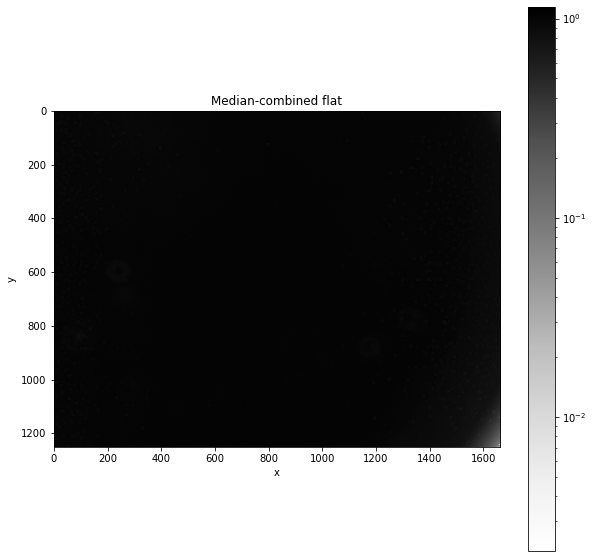

In [30]:
print('Statistics for median-combined flat image')

print(FlatR_median)

print('Min:', np.min(FlatR_median))
print('Max:', np.max(FlatR_median))
print('Median:', np.median(FlatR_median))
print('Std Dev:', np.std(FlatR_median))

fig, ax = plt.subplots(figsize = (10,10))
plt.imshow(FlatR_median, cmap = 'Greys', norm = LogNorm())
plt.title('Median-combined flat')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [31]:
FlatR_median.meta.update(EXPTIME = 1)        # add exposure time in seconds to header
FlatR_median.meta.update(TELESCOP = 'C14')   # add telescope used
FlatR_median.meta.update(OBJECT = 'Flat_R_Median')   # add name of object/image
FlatR_median.write("Flat_R_median.fits")    # save to file

In [32]:
# clear up some memory by deleting the flats and temporary images
del(flats)
del(tempimages)
collected = gc.collect()
print('Check garbage collection', collected)

Check garbage collection 12032
